# Master Thesis Notebook

# Modification test to look for comitting error

## Setup

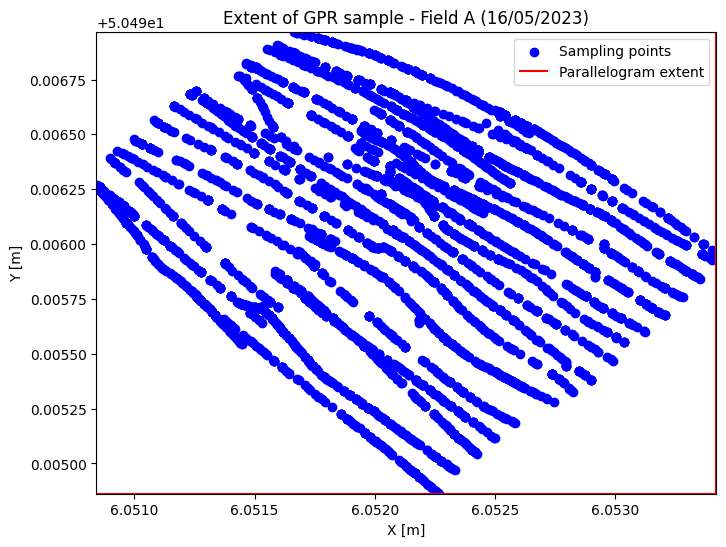

In [1]:
# Importation of the classes and methods associated
from classes import *

In [2]:
multi_a = MultispecAnalysis(
    temperature_raster=MultispecAnalysis.TEMPERATURE_RASTER, ndvi_raster=MultispecAnalysis.NDVI_RASTER
)

## GPR VWC Analysis

### Field A

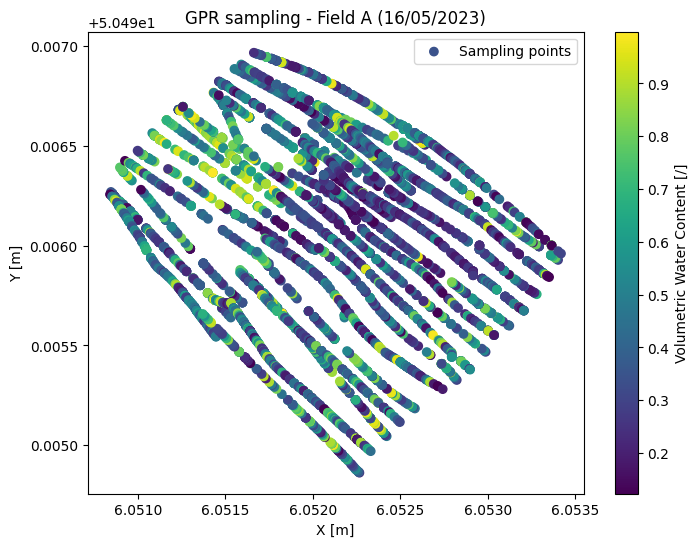

In [3]:
# Instance creation
gpr_a = GprAnalysis(field_paths=GprAnalysis.FIELD_A_PATHS, sample_number=0)  # Sample number [0-11] # FIELD_A/B_PATHS
# Raw Sample
gpr_a.plot_raw_sample(plot=True)

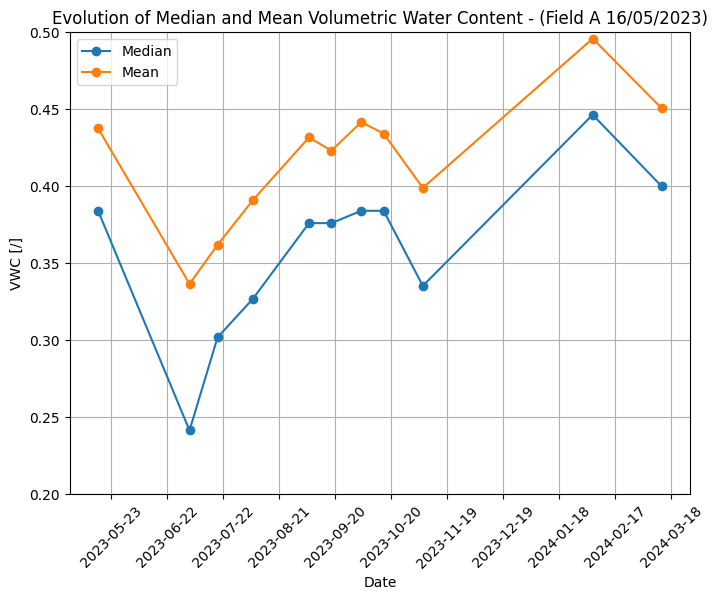

In [4]:
# Mean and median evolution (raw data)
gpr_a.plot_mean_median(plot=True)

### Field B

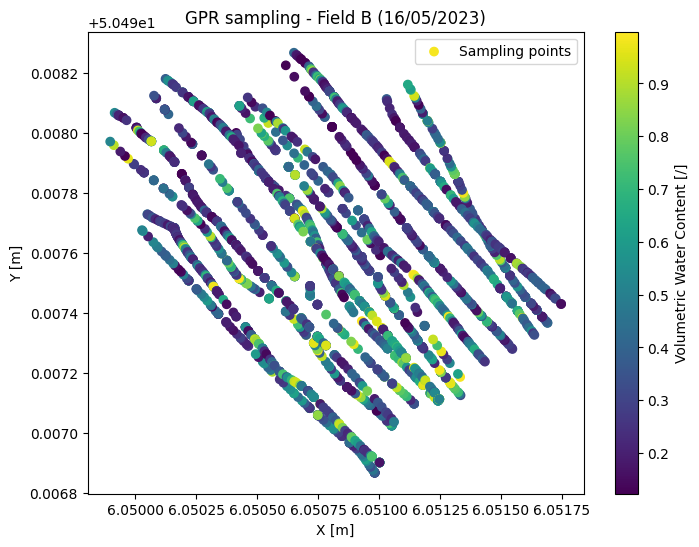

In [5]:
# Instance creation
gpr_b = GprAnalysis(field_paths=GprAnalysis.FIELD_B_PATHS, sample_number=0)  # Sample number [0-11] # FIELD_A/B_PATHS
# Raw Sample
gpr_b.plot_raw_sample(plot=True)

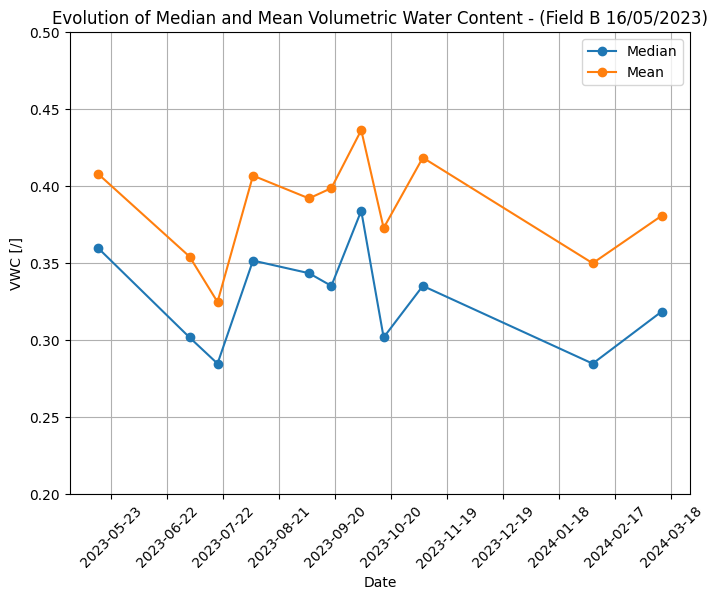

In [6]:
# Mean and median evolution (raw data)
gpr_b.plot_mean_median(plot=True)

## Kriging

## Field VWC data overview

In [7]:
# Read csv file
Studied_field = import_data(field_path)[sample_number]

# Convert latitude and longitude to UTM coordinates
utm_x, utm_y = transformer.transform(Studied_field["x"].values, Studied_field["y"].values)

# Plot the sampling points
plt.figure(figsize=(10, 6))
scatter = plt.scatter(utm_x, utm_y, c=Studied_field["vwc"], cmap="viridis", label="Sampling points")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title(f"Field {field_letter} GPR sampling {dates[sample_number]}")
cb = plt.colorbar(scatter)
cb.set_label("Volumetric Water Content [/]")
plt.grid(False)
plt.legend()
plt.show()

NameError: name 'import_data' is not defined

### Volumetric water content evolution of field A

In [ ]:
# Reset
gpr_data_tables = []
dates = []

gpr_data_tables = import_data(field_path)

mean_GPR_data_tables = []
for gpr_data_table in gpr_data_tables:
    mean_GPR_data_table = gpr_data_table["vwc"].mean()
    mean_GPR_data_tables.append(mean_GPR_data_table)

median_GPR_data_tables = []
for gpr_data_table in gpr_data_tables:
    median_GPR_data_table = gpr_data_table["vwc"].median()
    median_GPR_data_tables.append(median_GPR_data_table)

dates = extract_dates(field_path)

# Convert dates to datetime objects
dates = pd.to_datetime(dates, format="%d/%m/%Y")

plt.figure(figsize=(10, 6))
plt.plot(dates, median_GPR_data_tables, marker="o", label="Median")
plt.plot(dates, mean_GPR_data_tables, marker="o", label="Mean")
plt.xlabel("Date")
plt.ylabel("VWC [/]")
plt.title("Evolution of Median and Mean Volumetric Water Content on field A")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))
plt.ylim(0.2, 0.5)
plt.grid(True)
plt.legend()
plt.show()


# Reset
gpr_data_tables = []
dates = []

### Volumetric water content evolution of field B

In [ ]:
gpr_data_tables = import_data(field_b_paths)

mean_GPR_data_tables = []
for gpr_data_table in gpr_data_tables:
    mean_GPR_data_table = gpr_data_table.iloc[:, 2].mean()
    mean_GPR_data_tables.append(mean_GPR_data_table)

median_GPR_data_tables = []
for gpr_data_table in gpr_data_tables:
    median_GPR_data_table = gpr_data_table.iloc[:, 2].median()
    median_GPR_data_tables.append(median_GPR_data_table)

dates = extract_dates(field_b_paths)

# Convert dates to datetime objects
dates = pd.to_datetime(dates, format="%d/%m/%Y")

plt.figure(figsize=(10, 6))
plt.plot(dates, median_GPR_data_tables, marker="o", label="Median")
plt.plot(dates, mean_GPR_data_tables, marker="o", label="Mean")
plt.xlabel("Date")
plt.ylabel("VWC [/]")
plt.title("Evolution of Median and Mean Volumetric Water Content on field B")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))
plt.ylim(0.2, 0.5)
plt.grid(True)
plt.legend()
plt.show()

# Reset
gpr_data_tables = []
dates = []

## Kriging
Kriging is a type of interpolation that uses a semivariogram, which measures spatial autocorrelation (how similar close points are in value and how this similarity changes as distance between points increases). Thus, the semivariogram determines how much influence a known point has on an unknown point as the distance between the known point and the unknown point increases. In other words, the weight of a known point on an unknown point decreases with increasing distance, and the semivariogram determines how quickly that weight tapers with increasing distance

### Choosing the fitting Variogram Model

The semivariogram, often just referred to as the variogram, is used to quantify spatial dependence for irregularly spaced data. It computes the average variance of the difference between two data points with a given separation distance, or lag distance $\bf{h}$.

$$
\gamma(h) = \frac{1}{2 N(h)} \sum^{N}_{\alpha=1} (Z(x_\alpha) - Z(x_\alpha + h))^2  
$$


where $x$ is a spatial location, $Z(x)$ is a variable (e;g. water content), and $N$ is the number of lag distances.

We'll start by computing the isotropic variogram, which averages across different azimuthal directions using the Scikit GStat tools. 

In [ ]:
# grid data to ? m resolution
res = 0.00002
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(Studied_field, "x", "y", "vwc", res)

# remove nans
df_grid = df_grid[df_grid["Z"].isnull() == False]

# normal score transformation
data = df_grid["Z"].values.reshape(-1, 1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid["Nbed"] = nst_trans.transform(data)

# compute experimental (isotropic) variogram
coords = df_grid[["X", "Y"]].values
values = df_grid["Nbed"]

maxlag = 10  # maximum range distance
n_lags = 100  # num of bins

# compute variogram
V1 = skg.Variogram(coords, values, bin_func="even", n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.figure(figsize=(6, 4))
plt.scatter(xdata, ydata, s=12, c="g")
plt.title("Isotropic Experimental Variogram")
plt.xlabel("Lag (m)")
plt.ylabel("Semivariance")
plt.show()

In [ ]:
# use exponential variogram model
V1.model = "exponential"
V1.parameters

# use Gaussian model
V2 = V1
V2.model = "gaussian"
V2.parameters

# use spherical model
V3 = V1
V3.model = "spherical"
V3.parameters

# evaluate models
xi = np.linspace(0, xdata[-1], 100)

y_exp = [models.exponential(h, V1.parameters[0], V1.parameters[1], V1.parameters[2]) for h in xi]
y_gauss = [models.gaussian(h, V2.parameters[0], V2.parameters[1], V2.parameters[2]) for h in xi]
y_sph = [models.spherical(h, V3.parameters[0], V3.parameters[1], V3.parameters[2]) for h in xi]

# plot variogram model
fig = plt.figure()
plt.plot(xdata / 1000, ydata, "og", label="Experimental variogram")
plt.plot(xi / 1000, y_gauss, "b--", label="Gaussian variogram")
plt.plot(xi / 1000, y_exp, "r-", label="Exponential variogram")
plt.plot(xi / 1000, y_sph, "m*-", label="Spherical variogram")
plt.title("Isotropic variogram")
plt.xlabel("Lag [km]")
plt.ylabel("Semivariance")
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0)  # adjust the plot size
plt.legend(loc="lower right")

fig = plt.figure()
plt.plot(xdata / 1000, ydata, "og", label="Experimental variogram")
plt.plot(xi / 1000, y_gauss, "b--", label="Gaussian variogram")
plt.plot(xi / 1000, y_exp, "r-", label="Exponential variogram")
plt.plot(xi / 1000, y_sph, "m*-", label="Spherical variogram")
plt.title("Isotropic variogram")
plt.xlim(0, 0.0000003)
plt.xlabel("Lag [km]")
plt.ylabel("Semivariance")
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0)  # adjust the plot size
plt.legend(loc="lower right")

### Ordinary Kriging with exponential variogram

In [ ]:
# Define your prediction grid
x_min, x_max = min(Studied_field["x"]), max(Studied_field["x"])
y_min, y_max = min(Studied_field["y"]), max(Studied_field["y"])

gridx = np.arange(x_min, x_max, 0.00001)  # Adjust the step size as needed
gridy = np.arange(y_min, y_max, 0.00001)  # Adjust the step size as needed

In [ ]:
OK = OrdinaryKriging(
    Studied_field["x"],
    Studied_field["y"],
    Studied_field["vwc"],
    variogram_model="exponential",
    verbose=False,
    enable_plotting=False,
)

z, ss = OK.execute("grid", gridx, gridy)

In [ ]:
# Convert the kriging results to a suitable format for further processing or plotting
z_grid = z.T  # Transpose the result to match the grid shape

# Example: Convert to DataFrame for easy handling
result_df = pd.DataFrame(z_grid, index=gridx, columns=gridy)

In [ ]:
# Plot the interpolated surface

plt.imshow(z_grid, extent=[gridx.min(), gridx.max(), gridy.min(), gridy.max()], origin="lower", cmap="viridis")
plt.colorbar(label="Volumetric Water Content [/]")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.xticks(rotation=45)
plt.title(f"Interpolated Surface - Field {field_letter}")
plt.grid(False)

plt.tight_layout()
plt.show()

## Multispectral analysis

### TVDI

The formula used for the Temperature Vegetation Dryness Index (TVDI) calculation is:

$$ \text{TVDI} = \frac{\text{LST} - T_{\text{min}}(\text{NDVI})}{T_{\text{max}}(\text{NDVI}) - T_{\text{min}}(\text{NDVI})} $$

Where:
- LST is the Land Surface Temperature for a given pixel.
- T max NDVI is the maximum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{max}}(\text{NDVI}) = a \cdot \text{NDVI} + b $$
- T min NDVI is the minimum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{min}}(\text{NDVI}) = c \cdot \text{NDVI} + d $$

Here the specific linear functions used were:

$$ T_{\text{max}}(\text{NDVI}) = 40 \cdot \text{NDVI} + 300 $$

$$ T_{\text{min}}(\text{NDVI}) = 20 \cdot \text{NDVI} + 250 $$


In [ ]:
temperature_raster = "D:/Cours bioingé/BIR M2/Mémoire/Data/thermal/MR20240205_georeferenced_thermal_cali.tif"
ndvi_raster = "D:/Cours bioingé/BIR M2/Mémoire/Data/multispectral/NDVI/MR20230719_georeferenced_multi_ndvi.tif"
calculate_tvdi(temperature_raster, ndvi_raster)

## Multispectral vs GPR